Try only use information before the harvesting season, add el nino effect as a feature, remove year, March-April is bud break, see if weather in Nov - April have a effect on harvest date, take out 2007, 2009 and 2010 as testing

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
climate = pd.read_csv('climate.csv', sep='\t')
deliveries = pd.read_csv('deliveries.csv', sep='\t')

In [3]:
climate['crushdate'] = pd.to_datetime(climate['day'], format='%Y-%m-%d %H:%M:%S')
deliveries['crushdate'] = pd.to_datetime(deliveries['crushdate'], format='%m/%d/%y')

climate['year'] = climate['crushdate'].apply(lambda x: x.year).astype(int)
climate['month'] = climate['crushdate'].apply(lambda x: x.month).astype(int)
climate['day'] = climate['crushdate'].apply(lambda x: x.day).astype(int)

deliveries['year'] = deliveries['crushdate'].apply(lambda x: x.year).astype(int)
deliveries['month'] = deliveries['crushdate'].apply(lambda x: x.month).astype(int)
deliveries['day'] = deliveries['crushdate'].apply(lambda x: x.day).astype(int)

In [4]:
deliveries['tier'] = deliveries['programno'].apply(lambda x: x[:3])
deliveries['varietal'] = deliveries['programno'].apply(lambda x: x[3:6]).astype(int)
deliveries['origin'] = deliveries['programno'].apply(lambda x: x[6:])

In [5]:
# Look at one varietal first
v = deliveries[deliveries['varietal'] == 101]

In [6]:
v = v.sort_values(['crushdate', 'pblk'])
avg = v.groupby(['crushdate', 'pblk']).agg({'brix':np.mean, 'tons':np.mean})
#avg = v.groupby(['crushdate', 'pblk', 'tier']).agg({'brix':np.std})

v = v.drop(['brix', 'tons'], axis=1)
v = v.drop_duplicates(['crushdate', 'pblk'])

v['avg_brix'] = avg['brix'].tolist()
v['avg_tons'] = avg['tons'].tolist()

In [7]:
#m = avg.dropna(how='all').as_matrix()
#np.nanmean(m) 
#avg.head()

In [8]:
groups = v.groupby(['pblk', 'year', 'tier'])
sorted_group = sorted(groups, key=lambda x: len(x[1]), reverse=True)    

In [23]:
groups = v.groupby(['pblk', 'year', 'tier'])
for key, df in groups:
    print(df)
    break

    crushdate  year  month    pblk   avg_brix tier origin       long  \
0  2001-08-11  2001      8  100094  22.900000  TLV   CAL  -8493.8518   
38 2001-08-15  2001      8  100094  23.450000  TLV   CAL  -8493.8518   
49 2001-08-16  2001      8  100094  23.700001  TLV   CAL  -8493.8518   

          lat  yesterday_ddays50    ...      humidity_1  humidity_2  \
0   2666.9468              20.11    ...        5.165003   58.323101   
38  2666.9468              20.96    ...        5.165003   58.323101   
49  2666.9468              21.57    ...        5.165003   58.323101   

    humidity_3  cloud_cover_1  cloud_cover_2  cloud_cover_3    maxtemp_1  \
0     0.746172      53.801215     -17.179744     -16.226594  6636.494152   
38    0.746172      53.801215     -17.179744     -16.226594  6636.494152   
49    0.746172      53.801215     -17.179744     -16.226594  6636.494152   

    maxtemp_2  maxtemp_3  time_diff  
0    8.161382   0.982966         41  
38   8.161382   0.982966         45  
49   8.

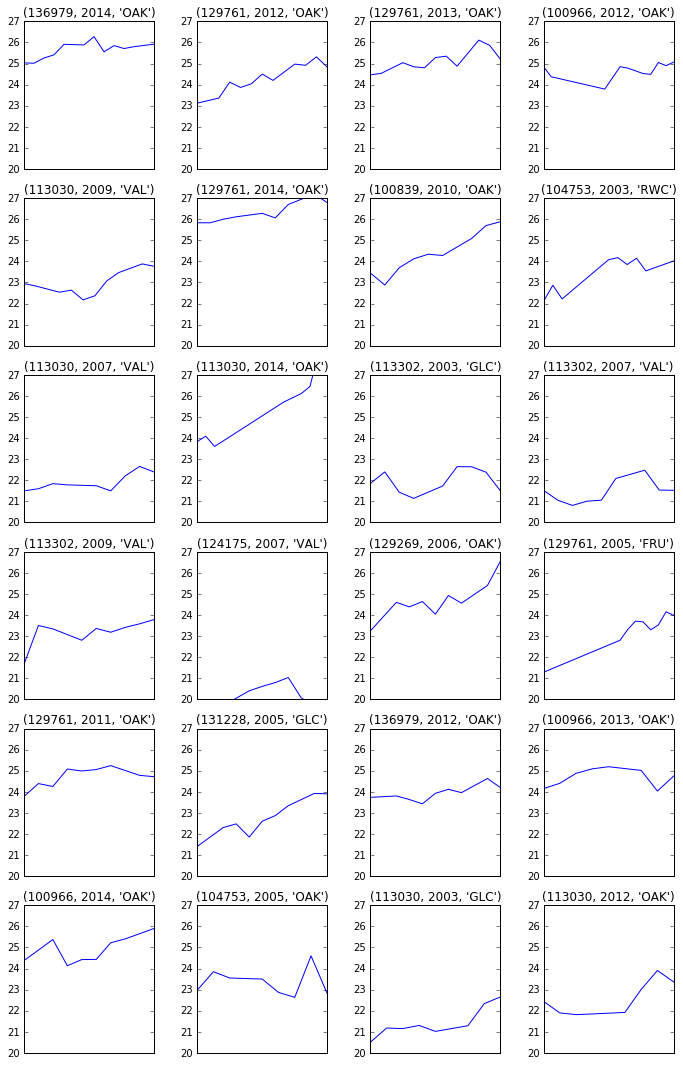

In [9]:
figure = plt.figure(figsize=(10, 15))
for i in range(0, 24):
    plt.subplot(6, 4, i + 1)
    plt.plot(sorted_group[i][1]['crushdate'], sorted_group[i][1]['avg_brix'])
    plt.title(sorted_group[i][0])
    plt.tight_layout()
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.ylim(20, 27)

# **The mean of standard deviation of brix level among the delivery on the same day from the same vineyard is 0.436

In [72]:
print(v.shape)
v.head()

(6103, 14)


,weighttagno,tagyear,siteno,programno,crushdate,pblk,year,month,day,tier,varietal,origin,avg_brix,avg_tons
66,793682,1,8,TLV101CAL,2001-08-11,100094,2001,8,11,TLV,101,CAL,22.900000,1.512525
78,793794,1,8,TLV101CAL,2001-08-11,101177,2001,8,11,TLV,101,CAL,23.200000,1.494967
64,793642,1,8,EJG101CAL,2001-08-11,101545,2001,8,11,EJG,101,CAL,22.571429,1.762500
67,793683,1,8,EJG101CAL,2001-08-11,101669,2001,8,11,EJG,101,CAL,21.675000,1.553650
79,793828,1,8,TLV101CAL,2001-08-11,102031,2001,8,11,TLV,101,CAL,23.550000,1.664950


In [73]:
columns = ['crushdate', 'year', 'month', 'day', 'pblk', 'avg_brix', 'tier', 'origin']
v = v[columns]

In [74]:
v['pblk'].astype(str).describe()

count       6103
unique       212
top       129761
freq         130
Name: pblk, dtype: object

In [75]:
# Add more columns to the dataframe using the climate data
# Columns to be added:
# logitude, latitude of the pblk
# ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp of yesterday
# average ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp for the past one week
# average ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp for the past one month
# average ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp for the past three month
# count of ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp that is greater than the mean for the past one week
# count of ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp that is greater than the mean for the past one month
# count of ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp that is greater than the mean for the past three month
# low rank approximation of ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp for each pblk

In [76]:
# Add longitude, latitude
location = climate[['pblk', 'long', 'lat']]
location = location.drop_duplicates(['pblk', 'long', 'lat'])
v = pd.merge(v, location, how="left", on='pblk')
v.head()

,crushdate,year,month,day,pblk,avg_brix,tier,origin,long,lat
0,2001-08-11,2001,8,11,100094,22.900000,TLV,CAL,-8493.8518,2666.9468
1,2001-08-11,2001,8,11,101177,23.200000,TLV,CAL,-8493.5375,2669.7853
2,2001-08-11,2001,8,11,101545,22.571429,EJG,CAL,-8472.4521,2634.5172
3,2001-08-11,2001,8,11,101669,21.675000,EJG,CAL,-8454.9913,2617.1782
4,2001-08-11,2001,8,11,102031,23.550000,TLV,CAL,-8483.9258,2667.5747


In [77]:
# Add ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp of yesterday
features = ['ddays50', 'ddays50_97', 'ddays97', 'humidity', 'cloud_cover', 'pressure', 'maxtemp', 
            'mintemp', 'meantemp', 'precip_intensity']
yesterday_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    yesterday = v.iloc[i].crushdate - timedelta(days=1)
    
    yesterday_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                                    (climate['year'] == yesterday.year) & 
                                    (climate['month'] == yesterday.month) & 
                                    (climate['day'] == yesterday.day)][features].iloc[0].tolist()

In [78]:
for feature in features:
    v['yesterday_' + feature] = yesterday_data[feature]

In [79]:
# Add average ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp for the past one week
last_week_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    yesterday = v.iloc[i].crushdate - timedelta(days=1)
    last_week = v.iloc[i].crushdate - timedelta(days=7)
    
    last_week_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                               (climate['crushdate'] >= last_week) & 
                               (climate['crushdate'] <= yesterday)][features].mean().tolist()

In [80]:
for feature in features:
    v['last_week_' + feature] = last_week_data[feature]

In [81]:
# Add average ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp for the past one week
last_month_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    yesterday = v.iloc[i].crushdate - timedelta(days=1)
    last_month = v.iloc[i].crushdate - timedelta(days=31)
    
    last_month_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                               (climate['crushdate'] >= last_month) & 
                               (climate['crushdate'] <= yesterday)][features].mean().tolist()
    
for feature in features:
    v['last_month_' + feature] = last_month_data[feature]

In [82]:
# Add average ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp for the past one week
last_2week_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    yesterday = v.iloc[i].crushdate - timedelta(days=1)
    last_2week = v.iloc[i].crushdate - timedelta(days=15)
    
    last_2week_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                               (climate['crushdate'] >= last_2week) & 
                               (climate['crushdate'] <= yesterday)][features].mean().tolist()
    
for feature in features:
    v['last_2week_' + feature] = last_2week_data[feature]

In [83]:
# Add average ddays50, ddays50_97, ddays97, humidity, cloud_cover, pressure, maxtemp, mintemp for the past one week
three_month_before_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    two_month_ago = v.iloc[i].crushdate - timedelta(days=62)
    three_month_ago = v.iloc[i].crushdate - timedelta(days=93)
    
    three_month_before_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                               (climate['crushdate'] >= three_month_ago) & 
                               (climate['crushdate'] <= two_month_ago)][features].mean().tolist()

In [84]:
three_month_before_data.head()

,ddays50,ddays50_97,ddays97,humidity,cloud_cover,pressure,maxtemp,mintemp,meantemp,precip_intensity
0,21.068710,20.007742,0.050323,0.502258,0.071613,1012.381290,88.663226,56.000645,71.068387,0.0
1,21.670000,20.541613,0.054839,0.486774,0.079677,1012.196452,89.232581,56.283548,71.669677,0.0
2,24.204194,23.330323,0.052581,0.424516,0.015806,1011.968387,90.922258,59.439677,74.204194,0.0
3,24.350323,23.609032,0.046452,0.438710,0.017097,1011.765484,91.285161,58.783548,74.350323,0.0
4,22.603871,21.410968,0.056129,0.463548,0.053871,1012.114194,90.033548,57.215484,72.603548,0.0


In [85]:
for feature in features:
    v['three_month_before_' + feature] = three_month_before_data[feature]

In [86]:
four_month_before_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    three_month_ago = v.iloc[i].crushdate - timedelta(days=93)
    four_month_ago = v.iloc[i].crushdate - timedelta(days=124)
    
    four_month_before_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                                (climate['crushdate'] >= four_month_ago) & 
                                (climate['crushdate'] <= three_month_ago)][features].mean().tolist()

In [87]:
four_month_before_data.head()

,ddays50,ddays50_97,ddays97,humidity,cloud_cover,pressure,maxtemp,mintemp,meantemp,precip_intensity
0,11.663548,11.663548,0.000000,0.600323,0.150968,1016.805161,76.804516,47.888065,60.764839,0.025697
1,12.034839,12.034839,0.000000,0.590000,0.148710,1016.702581,77.038387,48.287742,61.215806,0.024639
2,13.089355,13.089355,0.000000,0.541613,0.129032,1016.527742,78.553548,48.891290,62.305161,0.030390
3,12.967742,12.903871,0.000645,0.564516,0.140645,1016.402581,78.458387,48.140645,62.081613,0.036332
4,12.467097,12.467097,0.000000,0.572903,0.137419,1016.634194,77.744839,48.526452,61.670645,0.024706


In [88]:
for feature in features:
    v['four_month_before_' + feature] = four_month_before_data[feature]

In [89]:
five_month_before_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    four_month_ago = v.iloc[i].crushdate - timedelta(days=124)
    five_month_ago = v.iloc[i].crushdate - timedelta(days=155)
    
    five_month_before_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                                (climate['crushdate'] >= five_month_ago) & 
                                (climate['crushdate'] <= four_month_ago)][features].mean().tolist()

In [90]:
for feature in features:
    v['five_month_before_' + feature] = five_month_before_data[feature]

In [91]:
six_month_before_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    five_month_ago = v.iloc[i].crushdate - timedelta(days=155)
    six_month_ago = v.iloc[i].crushdate - timedelta(days=186)
    
    six_month_before_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                                (climate['crushdate'] >= six_month_ago) & 
                                (climate['crushdate'] <= five_month_ago)][features].mean().tolist()
    
for feature in features:
    v['six_month_before_' + feature] = six_month_before_data[feature]

In [92]:
seven_month_before_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    six_month_ago = v.iloc[i].crushdate - timedelta(days=186)
    seven_month_ago = v.iloc[i].crushdate - timedelta(days=217)
    
    seven_month_before_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                                (climate['crushdate'] >= seven_month_ago) & 
                                (climate['crushdate'] <= six_month_ago)][features].mean().tolist()
    
for feature in features:
    v['seven_month_before_' + feature] = six_month_before_data[feature]

In [93]:
eight_month_before_data = pd.DataFrame(columns=features)

for i in range(0, v.shape[0]):
    pblk = v.iloc[i].pblk
    seven_month_ago = v.iloc[i].crushdate - timedelta(days=217)
    eight_month_ago = v.iloc[i].crushdate - timedelta(days=248)
    
    eight_month_before_data.loc[i] = climate[(climate['pblk'] == pblk) & 
                                (climate['crushdate'] >= eight_month_ago) & 
                                (climate['crushdate'] <= seven_month_ago)][features].mean().tolist()
    
for feature in features:
    v['eight_month_before_' + feature] = six_month_before_data[feature]

In [18]:
v.to_csv('v201.csv', index=False)

# ----

In [16]:
v = pd.read_csv('v201.csv')
v['crushdate'] = pd.to_datetime(v['crushdate'], infer_datetime_format=True)

In [17]:
# Change the way time_diff is calculated
v['first_date'] = '-07-01'
v['year'] = v['year'].astype(str)
v['start_date'] = pd.to_datetime(v['year'] + v['first_date'], format='%Y-%m-%d')
v['time_diff'] = (v['crushdate'] - v['start_date']).astype('timedelta64[D]').astype(int)
v = v.drop(['first_date', 'start_date'], axis=1)

In [96]:
lr_ddays50 = pd.read_csv('lr_ddays50.csv')
lr_humidity = pd.read_csv('lr_humidity.csv')
lr_cloud_cover = pd.read_csv('lr_cloud_cover.csv')
lr_maxtemp = pd.read_csv('lr_maxtemp.csv')

lr_ddays50.head()

,ddays50_1,ddays50_2,ddays50_3,pblk
0,1611.355802,-12.218990,0.634748,100013
1,1367.716021,12.208003,-1.045634,100015
2,1370.836849,12.068548,-1.053069,100024
3,1727.012415,-16.562810,0.041056,100055
4,1346.071443,14.417660,-0.434827,100089


In [97]:
v = pd.merge(v, lr_ddays50, how="left", on='pblk')
v = pd.merge(v, lr_humidity, how="left", on='pblk')
v = pd.merge(v, lr_cloud_cover, how="left", on='pblk')
v = pd.merge(v, lr_maxtemp, how="left", on='pblk')

In [98]:
v.head()

,crushdate,year,month,day,pblk,avg_brix,tier,origin,long,lat,...,ddays50_3,humidity_1,humidity_2,humidity_3,cloud_cover_1,cloud_cover_2,cloud_cover_3,maxtemp_1,maxtemp_2,maxtemp_3
0,2001-08-11,2001,8,11,100094,22.900000,TLV,CAL,-8493.8518,2666.9468,...,-0.880299,5.165003,58.323101,0.746172,53.801215,-17.179744,-16.226594,6636.494152,8.161382,0.982966
1,2001-08-11,2001,8,11,101177,23.200000,TLV,CAL,-8493.5375,2669.7853,...,-0.438163,5.166123,58.343320,0.722323,54.070873,-17.434609,-16.148007,6644.420353,8.387873,0.768754
2,2001-08-11,2001,8,11,101545,22.571429,EJG,CAL,-8472.4521,2634.5172,...,-2.855970,4.854513,55.531924,-0.386679,63.004059,28.060896,10.997136,6776.373837,2.546416,-0.046823
3,2001-08-11,2001,8,11,101669,21.675000,EJG,CAL,-8454.9913,2617.1782,...,-1.393013,4.950029,56.548072,-0.549698,63.025726,27.942414,11.635398,6784.914007,1.323419,-1.048153
4,2001-08-11,2001,8,11,102031,23.550000,TLV,CAL,-8483.9258,2667.5747,...,-1.450714,5.067358,57.442546,0.318090,50.110882,-14.240416,-10.846082,6714.483520,7.168350,-0.065554


In [100]:
earliest_delivery

,year,earliest_date
0,2001.0,2001-08-11
1,2002.0,2002-08-14
2,2003.0,2003-08-23
3,2004.0,2004-07-26
4,2005.0,2005-08-15
5,2006.0,2006-08-16
6,2007.0,2007-08-06
7,2008.0,2008-08-12
8,2009.0,2009-08-13
9,2010.0,2010-08-19


In [101]:
v['time_diff'] = (v['crushdate'] - v['earliest_date']).astype('timedelta64[D]').astype(int)
v = v.drop(['day', 'earliest_date'], axis=1)

In [102]:
v.columns.tolist()

['crushdate',
 'year',
 'month',
 'pblk',
 'avg_brix',
 'tier',
 'origin',
 'long',
 'lat',
 'yesterday_ddays50',
 'yesterday_ddays50_97',
 'yesterday_ddays97',
 'yesterday_humidity',
 'yesterday_cloud_cover',
 'yesterday_pressure',
 'yesterday_maxtemp',
 'yesterday_mintemp',
 'yesterday_meantemp',
 'yesterday_precip_intensity',
 'last_week_ddays50',
 'last_week_ddays50_97',
 'last_week_ddays97',
 'last_week_humidity',
 'last_week_cloud_cover',
 'last_week_pressure',
 'last_week_maxtemp',
 'last_week_mintemp',
 'last_week_meantemp',
 'last_week_precip_intensity',
 'last_month_ddays50',
 'last_month_ddays50_97',
 'last_month_ddays97',
 'last_month_humidity',
 'last_month_cloud_cover',
 'last_month_pressure',
 'last_month_maxtemp',
 'last_month_mintemp',
 'last_month_meantemp',
 'last_month_precip_intensity',
 'last_2week_ddays50',
 'last_2week_ddays50_97',
 'last_2week_ddays97',
 'last_2week_humidity',
 'last_2week_cloud_cover',
 'last_2week_pressure',
 'last_2week_maxtemp',
 'last_2wee